In [2]:
import pandas as pd
import numpy as np
import datetime
from pprint import pprint
import matplotlib.pyplot as plt

%matplotlib inline

In [241]:
%%time
# запускать только для подгтовки датасетов
import load_month
import os
loader = load_month.TripsLoader()


folder = 'zip/'
files = [folder + x for x in os.listdir(folder) if x.endswith("csv.zip")]
files.sort()
files.remove(folder + 'yellow_tripdata_2016-06.csv.zip')
pprint(files)

df = None
df = pd.concat((loader.load_month(file_name=f)[1231] for f in files[-12:]))

['zip/yellow_tripdata_2015-01.csv.zip',
 'zip/yellow_tripdata_2015-02.csv.zip',
 'zip/yellow_tripdata_2015-03.csv.zip',
 'zip/yellow_tripdata_2015-04.csv.zip',
 'zip/yellow_tripdata_2015-05.csv.zip',
 'zip/yellow_tripdata_2015-06.csv.zip',
 'zip/yellow_tripdata_2015-07.csv.zip',
 'zip/yellow_tripdata_2015-08.csv.zip',
 'zip/yellow_tripdata_2015-09.csv.zip',
 'zip/yellow_tripdata_2015-10.csv.zip',
 'zip/yellow_tripdata_2015-11.csv.zip',
 'zip/yellow_tripdata_2015-12.csv.zip',
 'zip/yellow_tripdata_2016-01.csv.zip',
 'zip/yellow_tripdata_2016-02.csv.zip',
 'zip/yellow_tripdata_2016-03.csv.zip',
 'zip/yellow_tripdata_2016-04.csv.zip',
 'zip/yellow_tripdata_2016-05.csv.zip']
CPU times: user 2min 23s, sys: 11.2 s, total: 2min 34s
Wall time: 2min 33s


In [4]:
df.to_csv('data/1231.csv', sep=';', header=True)

In [243]:
df.head()

tpep_pickup_datetime
2016-03-01 00:00:00    389
2016-03-01 01:00:00    178
2016-03-01 02:00:00    128
2016-03-01 03:00:00     70
2016-03-01 04:00:00     65
Name: 1231, dtype: int64

In [244]:
df.shape[0]

2208

In [3]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/1231.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

,1231
tpep_pickup_datetime,
2015-06-01 00:00:00,231
2015-06-01 01:00:00,151
2015-06-01 02:00:00,90
2015-06-01 03:00:00,77
2015-06-01 04:00:00,75


In [4]:
df.index.weekday[::24]
# отлично, с понедельнкиа и начнем

Int64Index([0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            ...
            6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='tpep_pickup_datetime', length=366)

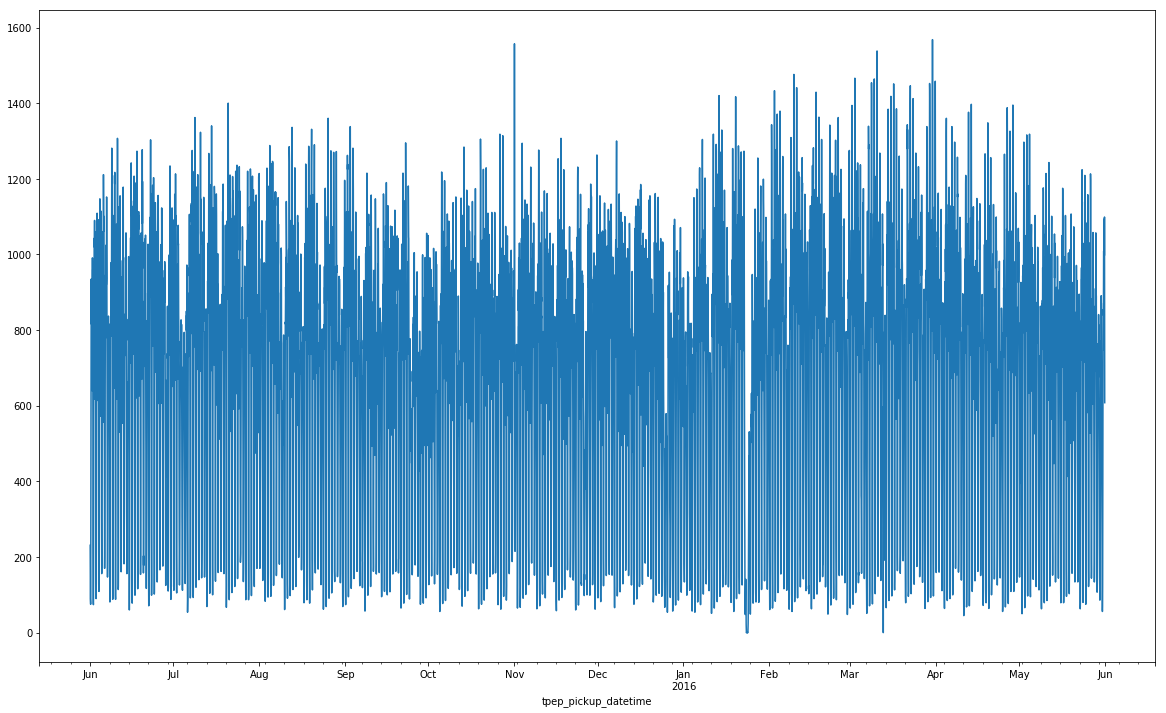

In [5]:
figsize=(20,12)
df['1231'].plot(figsize=figsize)

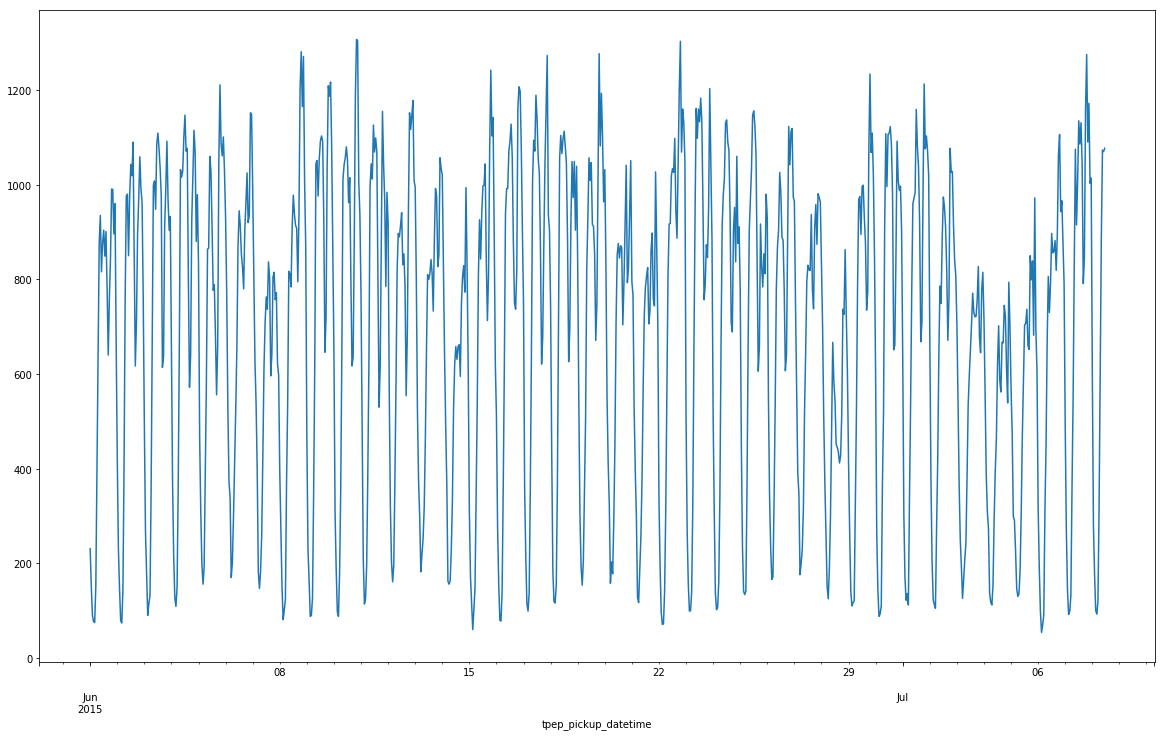

In [6]:
df['1231'][:900].plot(figsize=figsize)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
Y = df['1231'].values
t = np.arange(df.shape[0]) * np.pi / 168 * 2

cv_shuffle = ShuffleSplit(5, 0.2)
model = GradientBoostingRegressor()
k_list = []
for i in range(1, 8):
    k = i
    X = np.array([np.sin(t * k), np.cos(t * k)]).T
    scores = cross_validate(model, X, Y, cv=cv_shuffle)
    score = scores['test_score']
    if score.mean() > 0.4:
        print(k, score, np.mean(score))
        k_list.append(k)


1 [0.8280407  0.84068117 0.81512031 0.83857317 0.84866531] 0.8342161296365344
5 [0.5181451  0.51007424 0.51467639 0.51848731 0.52561546] 0.5173996982006014
7 [0.72705585 0.72202193 0.72561803 0.71762918 0.73991313] 0.7264476253329701


In [15]:
# учет праздников с плавающими датами
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()
pprint(tkd)

[datetime.date(2015, 5, 25),
 datetime.date(2015, 9, 7),
 datetime.date(2015, 11, 26),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 11, 24),
 datetime.date(2017, 5, 29),
 datetime.date(2017, 9, 4),
 datetime.date(2017, 11, 23),
 datetime.date(2018, 5, 28),
 datetime.date(2018, 9, 3),
 datetime.date(2018, 11, 22),
 datetime.date(2019, 5, 27),
 datetime.date(2019, 9, 2),
 datetime.date(2019, 11, 28)]


In [16]:
model = GradientBoostingRegressor()
t = np.arange(df.shape[0]) * np.pi / 168 * 2
l = []
for k in k_list:
    l.append(np.sin(t * k))
    l.append(np.cos(t * k))
    

# прирост в полпроцента и смягчение выбросов даст учет праздников
# праздники 4 июля, рождество, день памяти повышенный спрос
l.append([1 if (x.month == 7 and x.day == 4) \
          or (x.month == 12 and x.day in (24, 25, 26, 31)) \
          or (x.month == 1 and x.day == 1 and x.hour >= 8) \
          or (x.month == 5 and x.day >= 22 and x.date in tkd) \
          or (x.month == 9 and x.day <= 10 and x.date in tkd) \
          else 0 for x in df.index])
# в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
          or (x.month == 11 and x.day == 1 and x.hour < 3)
          or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
          else 0 for x in df.index])
# 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
# плюс мы уберем сильный выброс
l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23 and x.hour >=10) \
          or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
          else 0 for x in df.index])

for d in range(7):
    l.append([1 if x.weekday() == d else 0 for x in df.index])

t = np.arange(df.shape[0]) * np.pi / 8760 * 2
l.append(np.sin(t))
l.append(np.cos(t))
l.append(np.sin(t * 2))
l.append(np.cos(t * 2))
X = np.array(l).T
scores = cross_validate(model, X, Y, cv=cv_shuffle)
print(scores['test_score'], scores['test_score'].mean())

[0.90395654 0.90789355 0.90254561 0.89678751 0.89916287] 0.9020692170226733


In [17]:
model.fit(X, Y)
print('model score:', model.score(X, Y))
df['pred'] = model.predict(X)
df['dif'] = (df['pred'] - df['1231'])
# хорошая модель получилась

model score: 0.9072655592097943


In [124]:
model.feature_importances_

array([0.07015363, 0.06027931, 0.04278053, 0.0285934 , 0.16343794,
       0.15914336, 0.02187138, 0.03475874, 0.08892556, 0.03542438,
       0.02681544, 0.01621474, 0.02193624, 0.00020871, 0.        ,
       0.        , 0.        , 0.01457145, 0.        , 0.00095607,
       0.07353859, 0.05441712, 0.06215083, 0.02382256])

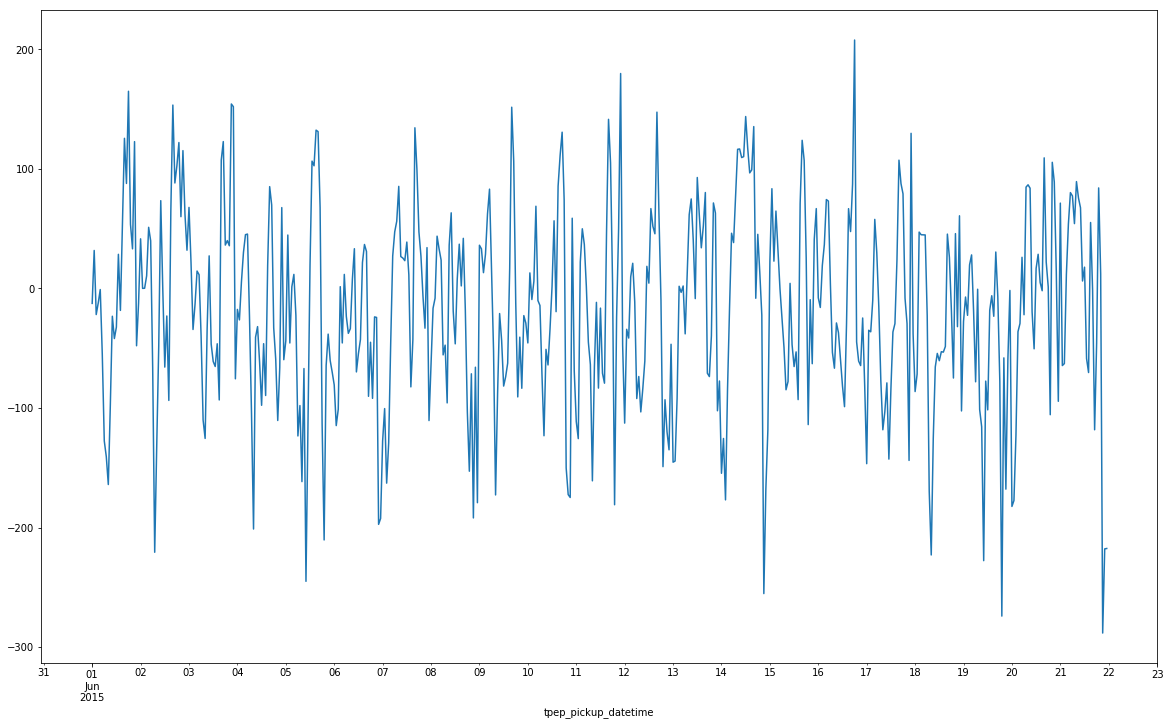

In [125]:
df.dif[:168*3].plot(figsize = (20, 12))

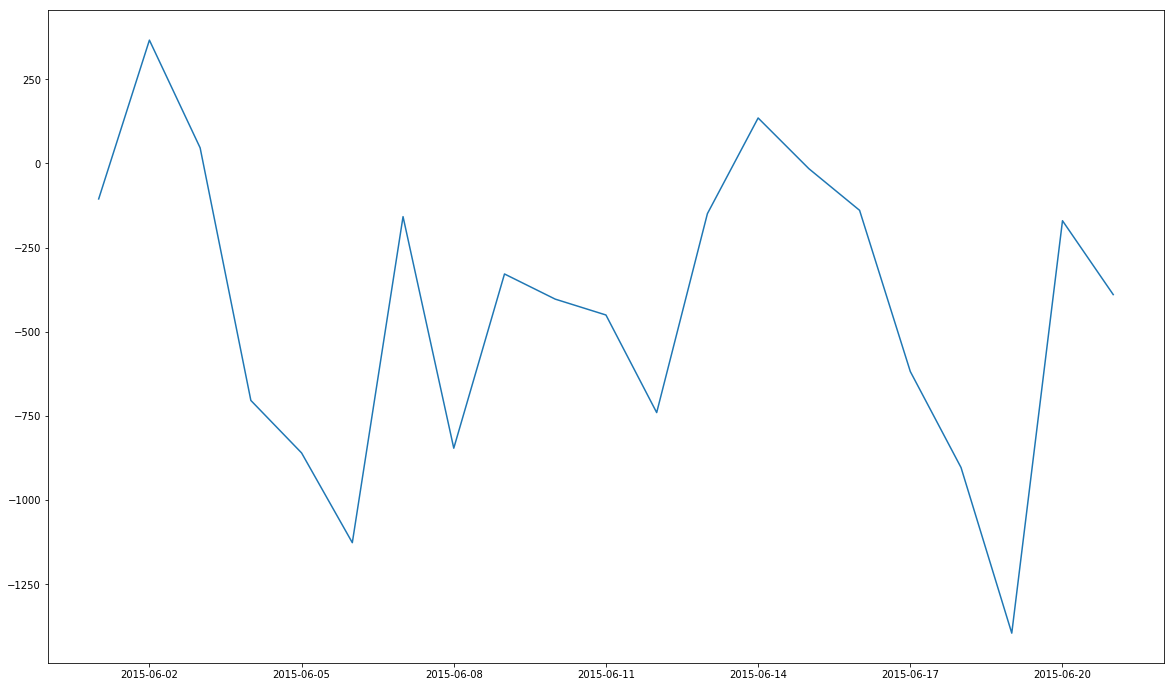

In [126]:
df.dif.groupby(df.index.date).sum()[:21].plot(figsize = (20, 12))
# первые три недели. недельная сезонность не наблюдается, будем работать с дневной

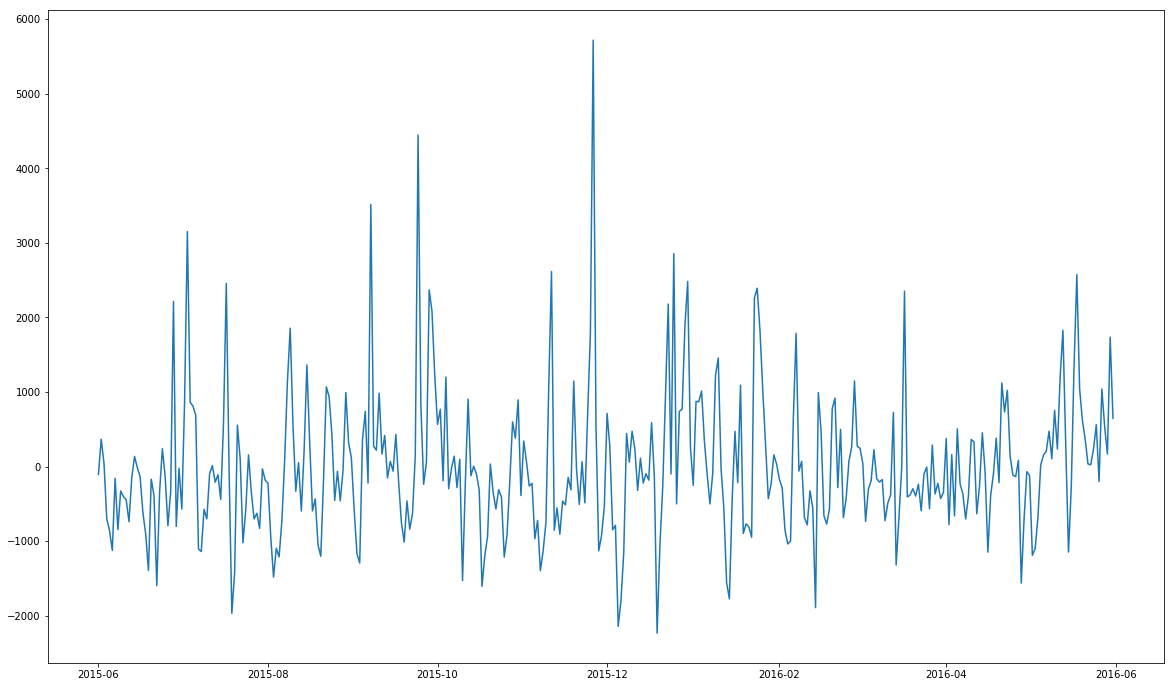

In [188]:
df.dif.groupby(df.index.date).sum().plot(figsize = (20, 12))
# много выбросов влияют на результат

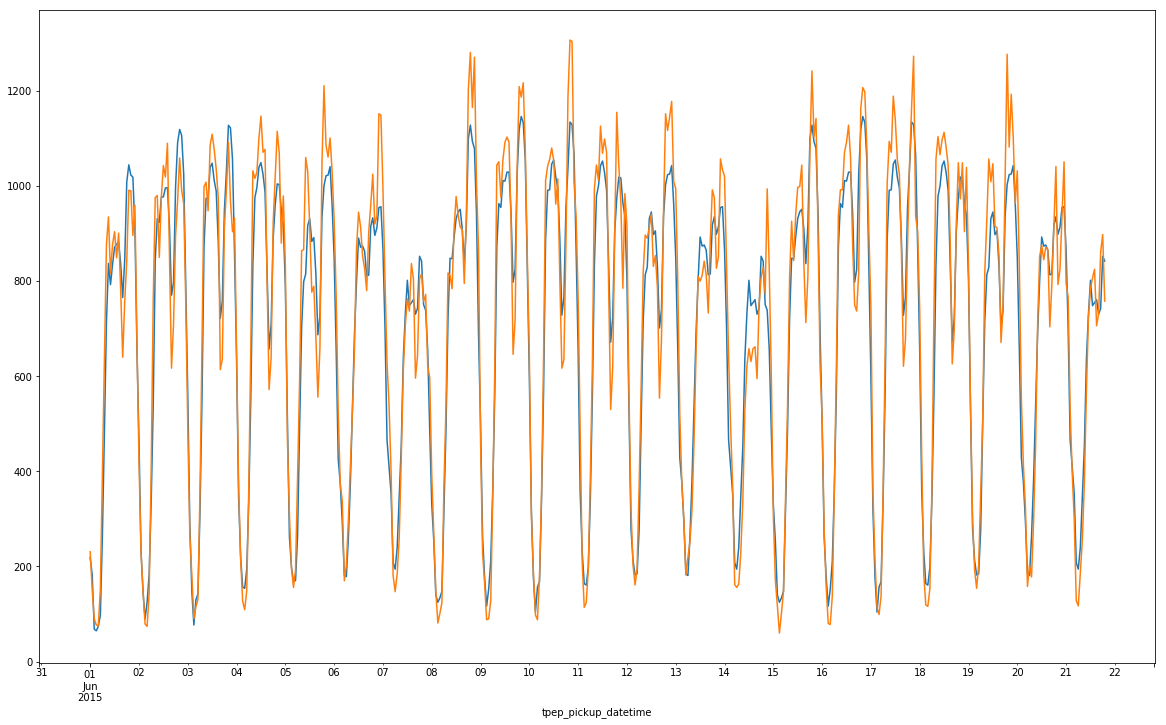

In [189]:
df['pred'][:500].plot(figsize=figsize)
df['1231'][:500].plot(figsize=figsize)
# выглядит неплохо, попробуем добавить SARIMAX

In [190]:
df.dif[df.dif.abs() > 500][:]
# мы все еще предсказываем намного больше на день благодарения

tpep_pickup_datetime
2015-11-26 08:00:00    620.004970
2015-11-26 09:00:00    680.494233
2015-11-26 10:00:00    568.189920
2015-11-26 11:00:00    528.794161
2015-11-26 13:00:00    553.772046
Name: dif, dtype: float64

<Figure size 1440x864 with 0 Axes>

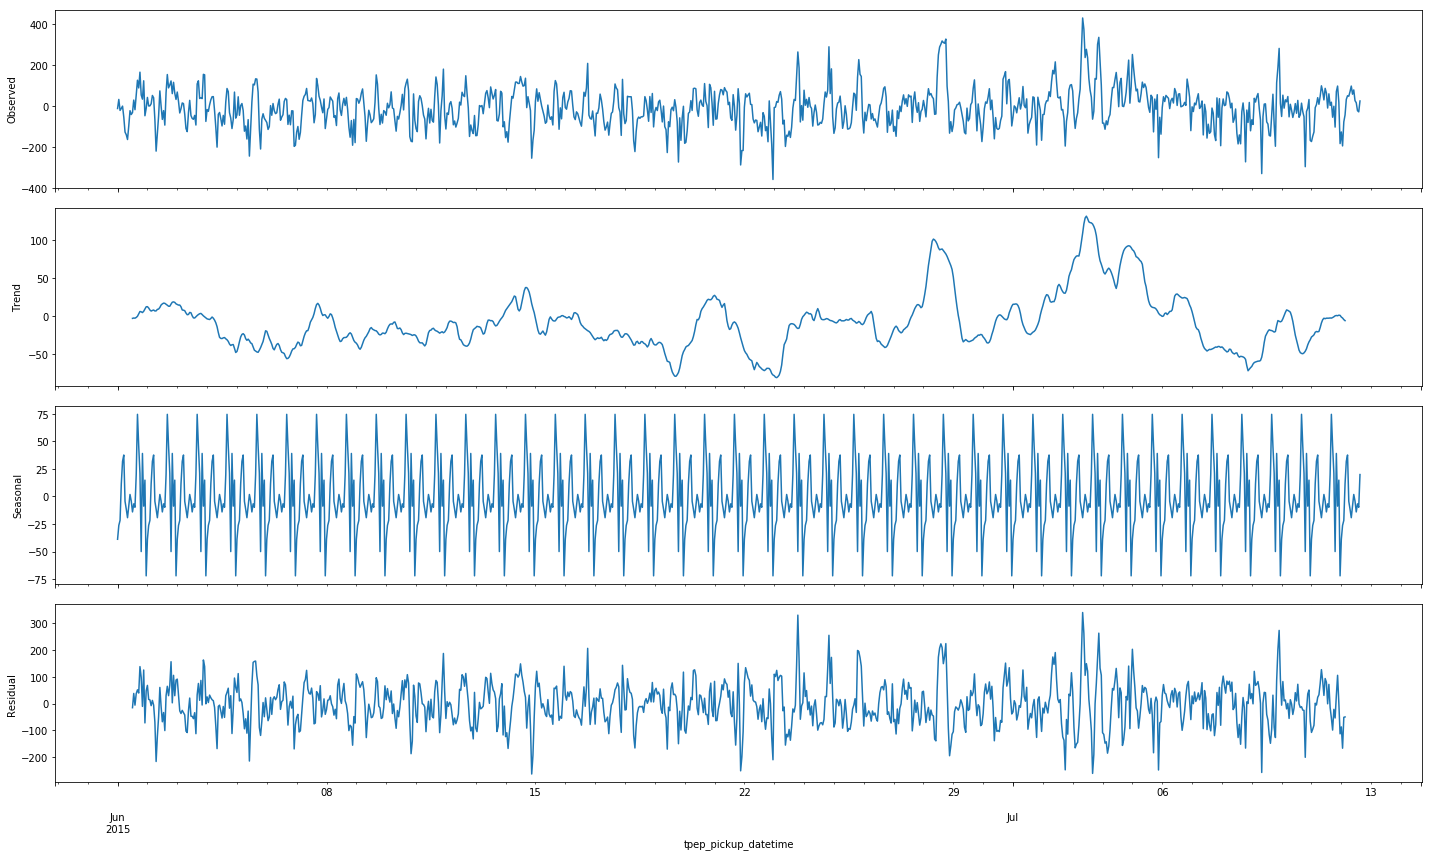

In [191]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
fig = plt.figure(figsize=figsize)
sm.tsa.seasonal_decompose(df.dif[:1000]).plot()
plt.show()

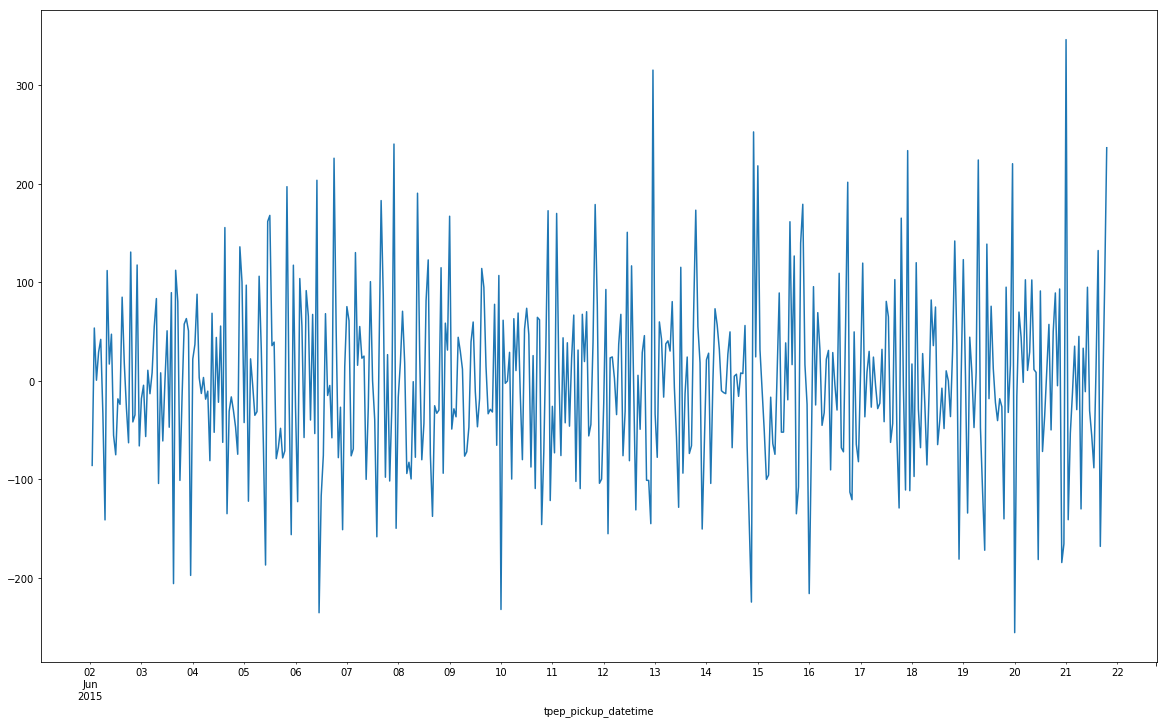

In [192]:
# произведем дифференцирование по дням и на один час
df['dif_shift1d'] = df.dif - df.dif.shift(24)
df['dif_shift1h'] = df.dif_shift1d - df.dif_shift1d.shift(1)

df.dif_shift1h[:500].plot(figsize=figsize)

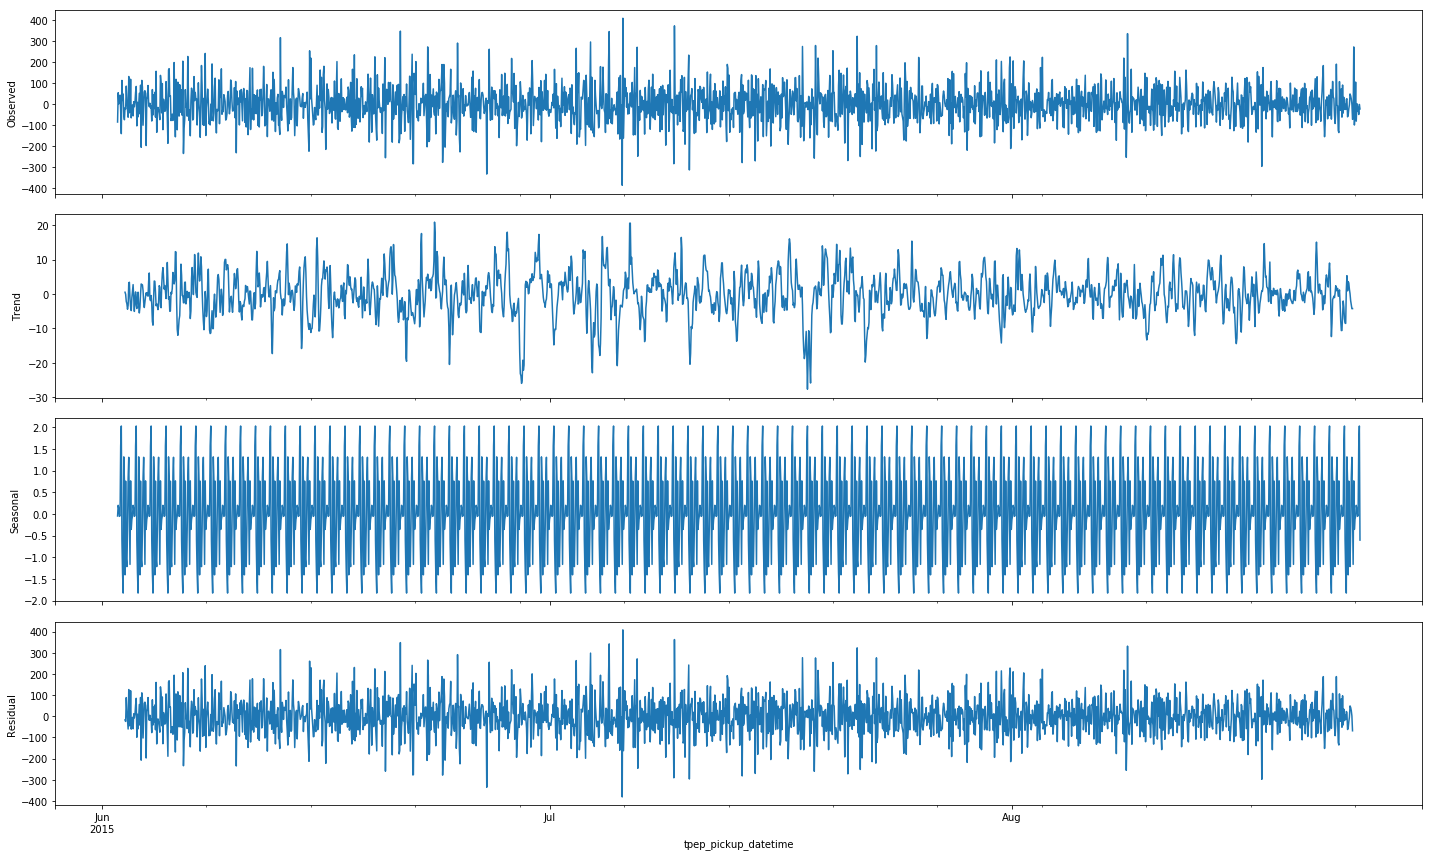

In [193]:
start = 24+1
end = 2000 + start
decomposition = sm.tsa.seasonal_decompose(df.dif_shift1h[start:end])
fig = decomposition.plot()
plt.show()

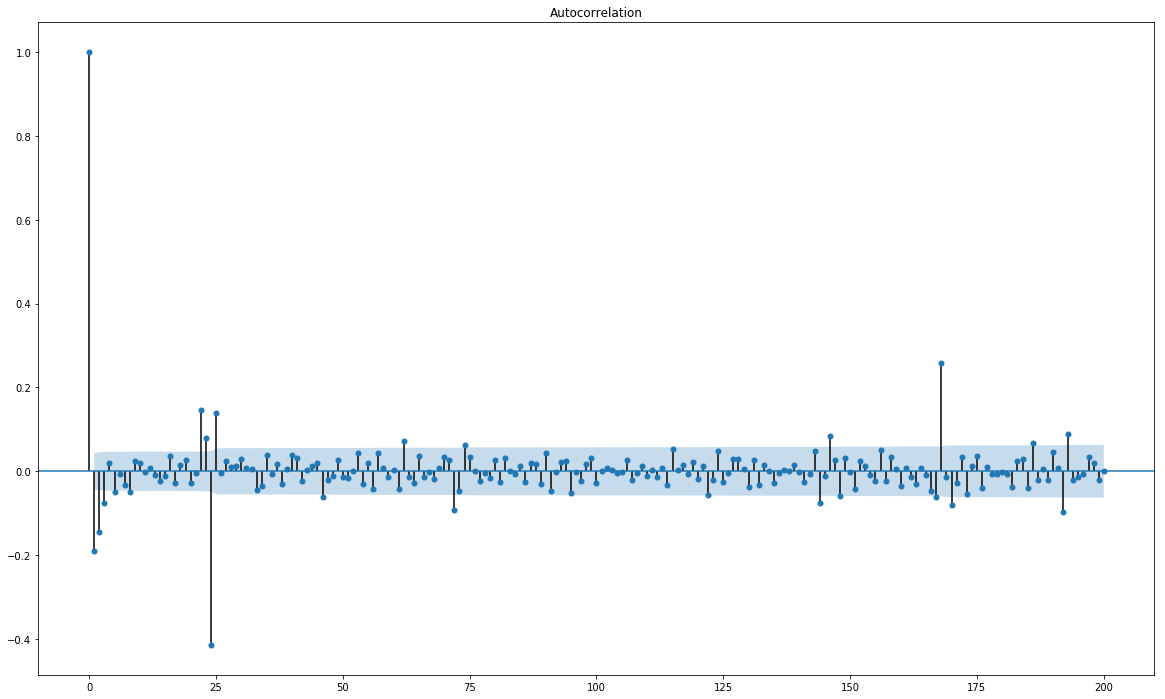

In [194]:
sm.graphics.tsa.plot_acf(df.dif_shift1h.values[start:end].squeeze(), lags=200)
plt.show()

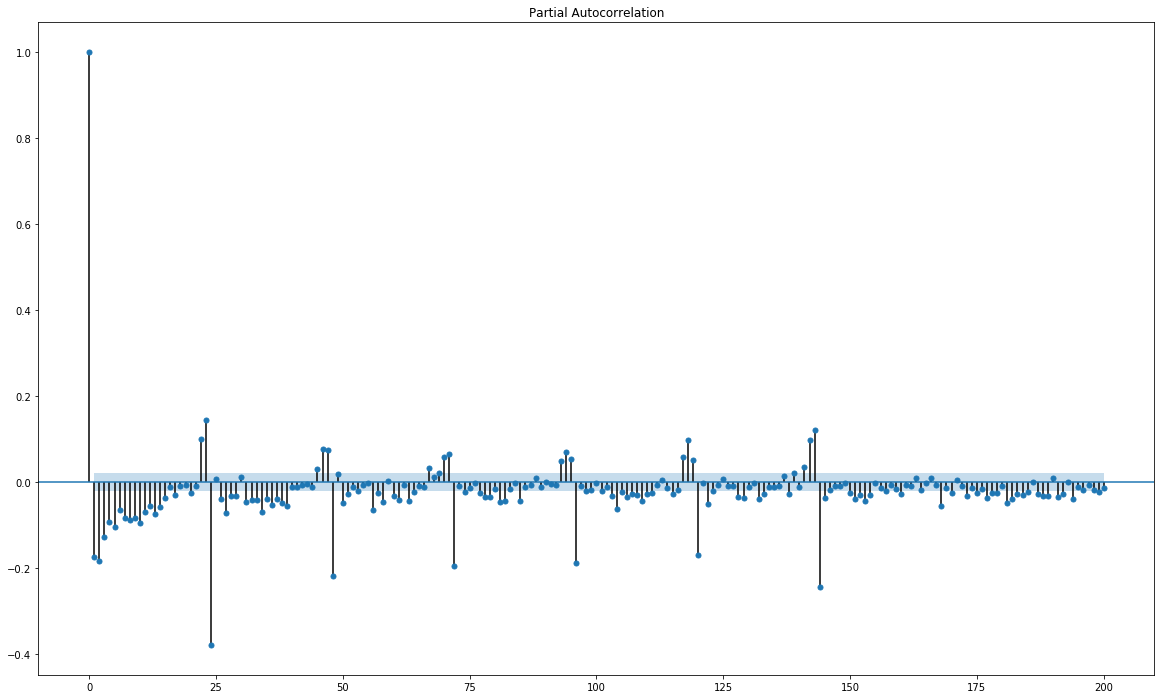

In [195]:
sm.graphics.tsa.plot_pacf(df.dif_shift1h.values[start:].squeeze(), lags=200)
plt.show()

In [245]:
q = 3
Q = 7
p = 15 # большие значения увиличивают время вычисления
P = 6
d = 1
D = 1
# проигнорируем seasonal_order в переборе для ускорения расчетов

In [246]:
%%time
endog = df['1231']
exog = df.pred
#  
model=sm.tsa.statespace.SARIMAX(endog, exog,
                                order=(p, d, q),
                                enforce_invertibility=False
                               ).fit(disp=-1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1min 25s, sys: 762 ms, total: 1min 26s
Wall time: 45.9 s


In [263]:
print(model.aic)

99377.40158692554


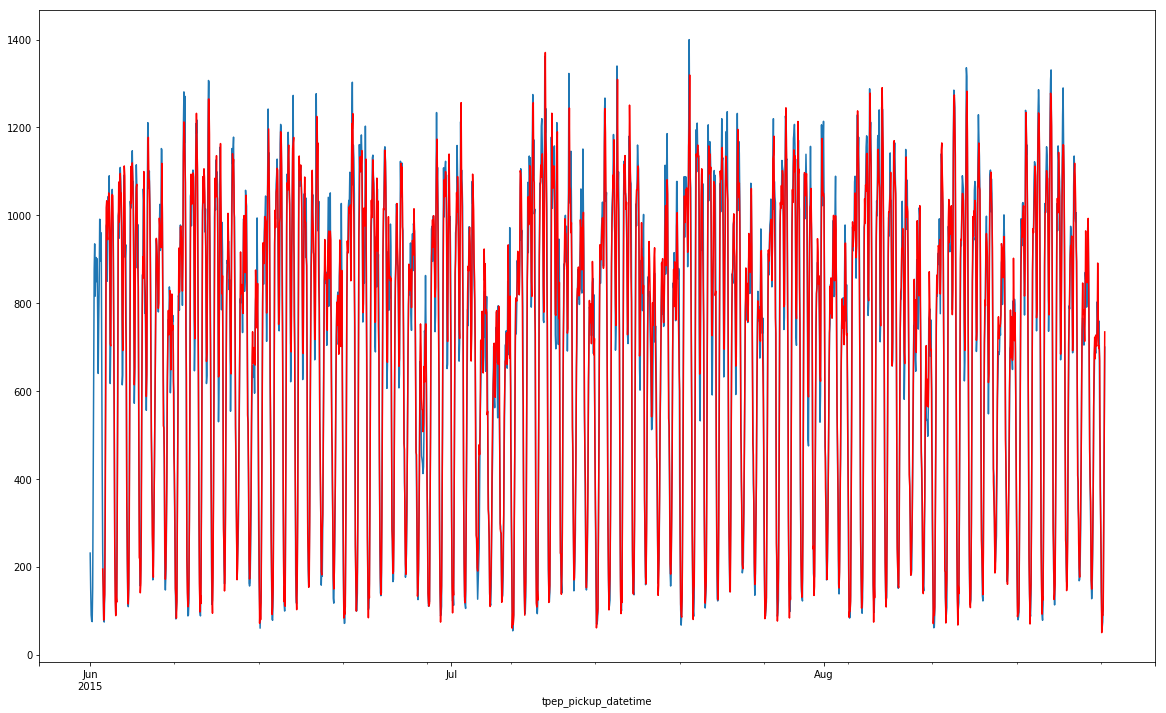

In [264]:
df['arima'] = model.fittedvalues
plt.figure(figsize=figsize)
df['1231'][:end].plot()
df.arima[start:end].plot(color='r')
plt.show()

In [251]:
from sklearn.metrics import r2_score
score = r2_score(Y[start:], df.arima[start:].values)
print('+arima:', score)

score = r2_score(Y, df.pred.values)
print('only gboost', score)
# арима помогает, переберм параметры
# 95% + хороший результат

+arima: 0.9592259283239863
only gboost 0.9223920446511839


In [252]:
ps = range(p + 1)
d=1
qs = range(q + 1)

In [253]:
from itertools import product
import warnings
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [254]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog, exog,
                                        order=(param[0], d, param[1]),
                                        enforce_invertibility=False 
                                       ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 3)
wrong parameters: (4, 3)
wrong parameters: (5, 3)
wrong parameters: (6, 3)
wrong parameters: (7, 3)
wrong parameters: (8, 3)
CPU times: user 27min 24s, sys: 9.61 s, total: 27min 33s
Wall time: 14min 1s


In [256]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
# подобранная модель лучше первой по AIC, возьмем ее для предсказывания

   parameters           aic
57    (15, 3)  99377.401587
56    (15, 2)  99408.060308
51    (14, 1)  99418.823139
49    (13, 3)  99419.502753
55    (15, 1)  99420.537608


In [257]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                   1231   No. Observations:                 8784
Model:              SARIMAX(15, 1, 3)   Log Likelihood              -49668.701
Date:                Sun, 08 Jul 2018   AIC                          99377.402
Time:                        18:57:16   BIC                          99519.013
Sample:                    06-01-2015   HQIC                         99425.647
                         - 05-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pred           1.0392      0.006    185.004      0.000       1.028       1.050
ar.L1         -0.5075      0.040    -12.715      0.000      -0.586      -0.429
ar.L2          0.0016      0.031      0.052      0.9

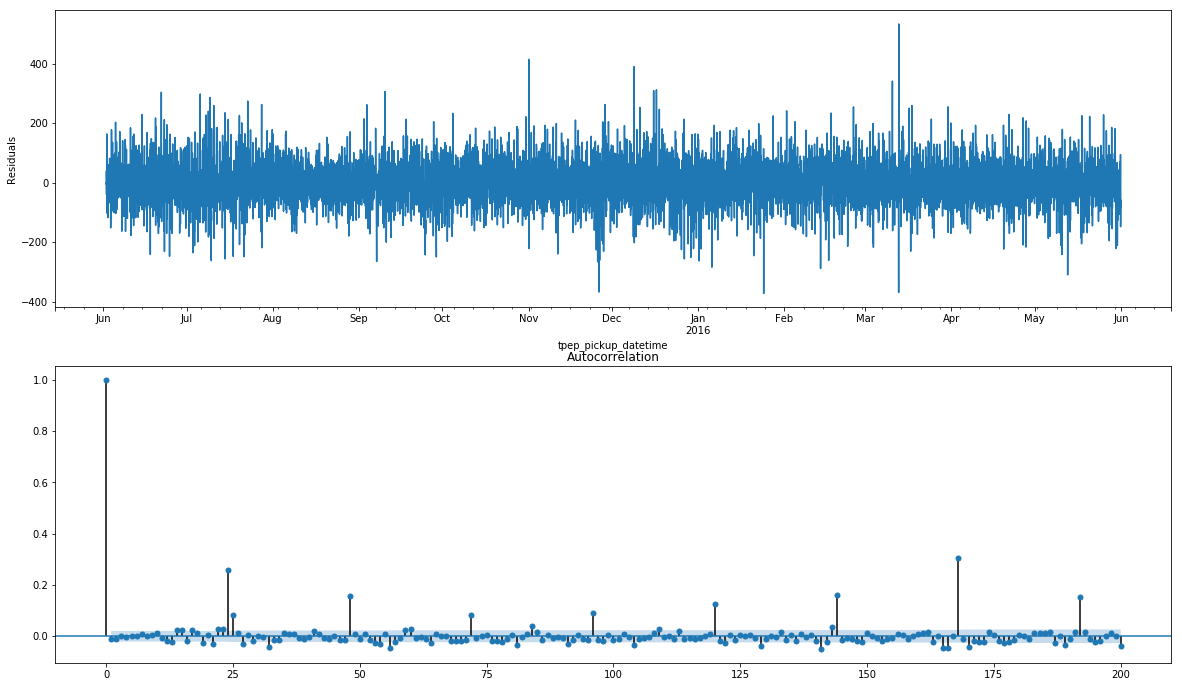

In [260]:
plt.figure(figsize=figsize)
plt.subplot(211)
best_model.resid[start:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[start:].values.squeeze(), lags=200, ax=ax)
plt.show()
# сохраняется дневная сезонность

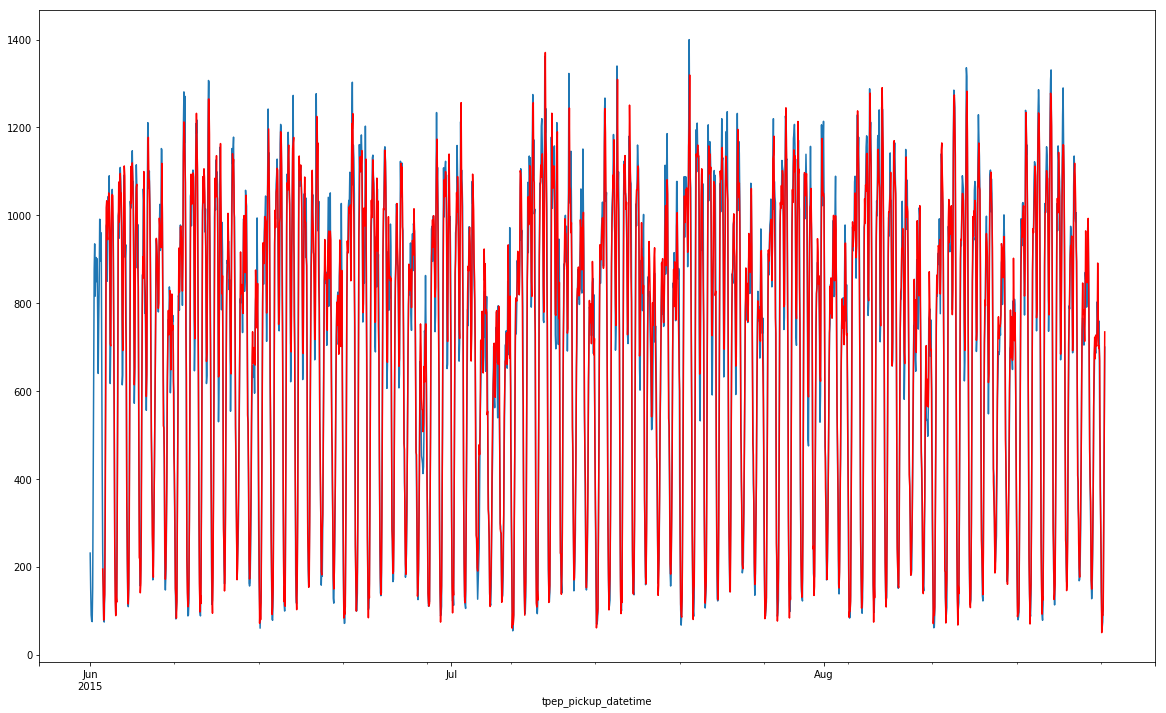

In [261]:
df['arima'] = best_model.fittedvalues
plt.figure(figsize=figsize)
df['1231'][:end].plot()
df.arima[start:end].plot(color='r')
plt.show()

In [262]:
df['arima'] = best_model.fittedvalues
score = r2_score(Y[start:1000], df.arima[start:1000].values)
print('+arima:', score)

score = r2_score(Y, df.pred.values)
print('only gboost', score)
#  95.+%, неплохо, лучше чем только регрессия

+arima: 0.9525945029593976
only gboost 0.9223920446511839


In [268]:
%%time
# проверим, поможет ли учет сезонности
model=sm.tsa.statespace.SARIMAX(endog, exog,
                                order=(p, d, q),
                                seasonal_order=(1, D, 1, 24),
                                enforce_invertibility=False
                               ).fit(disp=-1)
# с минимальными паамтерами сезонности ноутбучный процессор обрабатывает данные за 12 минут
# при повышении P, Q время просчета значительно вырастает

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 23min 20s, sys: 2.65 s, total: 23min 22s
Wall time: 11min 44s


In [269]:
print(model.aic)

98073.60755827963


In [271]:
df['arima_season'] = model.fittedvalues
score = r2_score(Y[start:], df.arima_season[start:].values)
print('+arima_season:', score)
score = r2_score(Y[start:], df.arima[start:].values)
print('+arima:', score)

score = r2_score(Y, df.pred.values)
print('only gboost', score)
# сезонность с минимальными параметрами дает выигрыш в пол процента итого 96%+. весьма хороший результат.

+arima_season: 0.9638022310564367
+arima: 0.9592259283239863
only gboost 0.9223920446511839


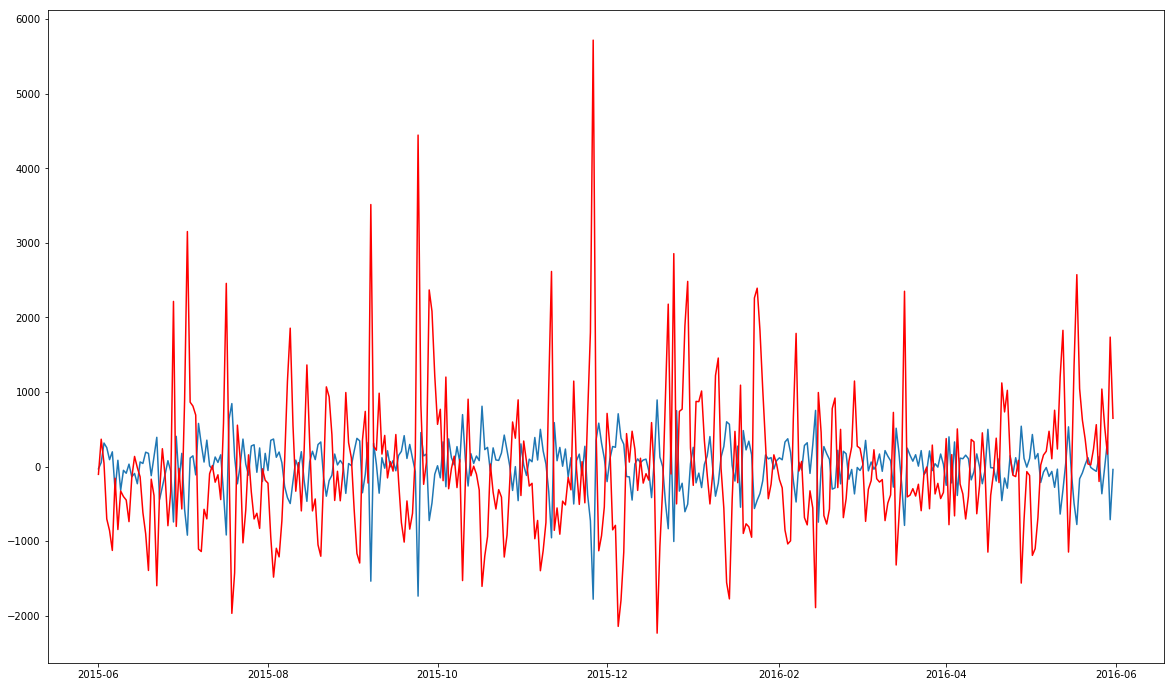

In [275]:
df['dif_sarimax'] = df['1231'] - df.arima_season
df.dif_sarimax.groupby(df.index.date).sum().plot(figsize = (20, 12))
df.dif.groupby(df.index.date).sum().plot(figsize = (20, 12), color='r')
# экстремумы стали менее экстремальные и их кол-во стало меньше, остатки ближе к нулю, чем при обычной регрессии, 

In [277]:
df.dif_sarimax[df.dif_sarimax.abs() > 500][:]
# ошибки на 500+ ушли

tpep_pickup_datetime
2016-03-13 03:00:00    518.775424
Name: dif_sarimax, dtype: float64

In [284]:
df.dif_sarimax[df.dif_sarimax.abs() > 300][:]
# ошибок на 300 - 9 из 8
#  13 марта был перевод часов на летнее время
# 01-24 последствия сильног оснегопада
# чтобы выгадать десятую процента, можно еще и их учесть

tpep_pickup_datetime
2015-07-05 21:00:00    301.108384
2015-09-10 07:00:00    308.161125
2015-11-01 01:00:00    354.826082
2015-11-25 20:00:00   -342.629768
2015-11-26 08:00:00   -339.165677
2015-12-08 23:00:00    385.286775
2016-01-24 13:00:00   -379.066157
2016-03-13 02:00:00   -406.881797
2016-03-13 03:00:00    518.775424
Name: dif_sarimax, dtype: float64